In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import tqdm
import torchdiffeq
import pytorch_lightning

from case_studies.dc2_mdt.utils.flow_matching import (ConditionalFlowMatcher, 
                                                      ExactOptimalTransportConditionalFlowMatcher)

In [3]:
device = torch.device("cuda:6")

In [4]:
pytorch_lightning.seed_everything(7272)

Seed set to 7272


7272

In [5]:
def generate_source(batch_size):
    return torch.randn(batch_size, 2) * 0.1

def eight_normal_sample(batch_size, center_scale=1, noise_scale=0.05):
    centers = torch.tensor([
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / math.sqrt(2), 1.0 / math.sqrt(2)),
        (1.0 / math.sqrt(2), -1.0 / math.sqrt(2)),
        (-1.0 / math.sqrt(2), 1.0 / math.sqrt(2)),
        (-1.0 / math.sqrt(2), -1.0 / math.sqrt(2)),
    ])
    centers = centers * center_scale
    noise = torch.randn(batch_size, 2) * noise_scale
    multi = torch.multinomial(torch.ones(8), 
                              batch_size, 
                              replacement=True)
    return centers[multi] + noise, multi

In [6]:
source_data = generate_source(1024)
target_data, target_labels = eight_normal_sample(1024)

In [7]:
source_data.shape, target_data.shape, target_labels.shape

(torch.Size([1024, 2]), torch.Size([1024, 2]), torch.Size([1024]))

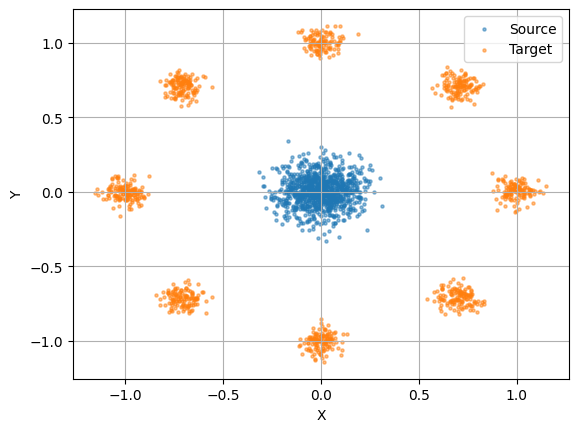

In [8]:
plt.scatter(source_data[:, 0], source_data[:, 1],
            s=5, alpha=0.5, label="Source")
plt.scatter(target_data[:, 0], target_data[:, 1],
            s=5, alpha=0.5, label="Target")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [9]:
class FourierMLP(nn.Module):
    def __init__(self, num_layers, hidden_ch):
        super().__init__()

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.label_embed = nn.Embedding(8, embedding_dim=hidden_ch)
        self.input_embed = nn.Sequential(
            nn.Linear(2, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )

        self.layers_net = nn.ModuleList([
            nn.Linear(hidden_ch * 2, hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), 
                              nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, 2),
        ])

    def layers(self, x):
        for i, m in enumerate(self.layers_net):
            if i < 2 or i == len(self.layers_net) - 1:
                x = m(x)
                continue
            x = m(x) + x
        return x

    def forward(self, x, t, labels):
        if t.ndim == 0:
            t = t.repeat(x.shape[0])
        assert t.ndim == 1
        t = t.unsqueeze(-1)  # (b, 1)
        assert labels.ndim == 1
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(torch.cat([sin_embed_t, 
                                                 cos_embed_t], 
                                                dim=-1))
        embed_labels = self.label_embed(labels)
        embed_xt = self.input_embed(x)

        return self.layers(
            torch.cat([embed_xt + embed_t, embed_labels], dim=-1)
        )

In [10]:
training_iters = 30_000
batch_size = 128
test_batch_size = batch_size * 10
fm_type = "ot"

match fm_type:
    case "ot":
        fm = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0, 
                                                         discrete_labels_guide=True)
    case "vanilla":
        fm = ConditionalFlowMatcher(sigma=0.0)
    case _:
        raise NotImplementedError()

my_net = FourierMLP(num_layers=8, hidden_ch=128).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, 
                                                    milestones=[training_iters // 5 * 4], 
                                                    gamma=0.1)

In [11]:
my_net.train()
loss_record = []
for step_i in tqdm.tqdm(list(range(training_iters))):
    my_optimizer.zero_grad()

    source_data = generate_source(batch_size)
    target_data, target_labels = eight_normal_sample(batch_size)
    source_data = source_data.to(device=device)
    target_data = target_data.to(device=device)
    target_labels = target_labels.to(device=device)

    match fm_type:
        case "ot":
            t, xt, ut, _, target_labels = fm.guided_sample_location_and_conditional_flow(x0=source_data, 
                                                                                        x1=target_data, 
                                                                                        y1=target_labels)
        case "vanilla":
            t, xt, ut = fm.sample_location_and_conditional_flow(x0=source_data, 
                                                                x1=target_data)
        case _:
            raise NotImplementedError()
        
    vt = my_net(x=xt, t=t, labels=target_labels)

    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    loss_record.append(loss.item())

    if (step_i + 1) % 500 == 0:
        print(f"[{step_i + 1}/{training_iters}] loss: {loss.item():.3e}")

  2%|▏         | 510/30000 [00:08<07:18, 67.31it/s]

[500/30000] loss: 4.123e-03


  3%|▎         | 1007/30000 [00:15<07:19, 65.91it/s]

[1000/30000] loss: 2.848e-03


  5%|▌         | 1507/30000 [00:23<07:06, 66.74it/s]

[1500/30000] loss: 2.661e-03


  7%|▋         | 2011/30000 [00:30<07:00, 66.53it/s]

[2000/30000] loss: 2.848e-03


  8%|▊         | 2509/30000 [00:38<06:55, 66.22it/s]

[2500/30000] loss: 2.879e-03


 10%|█         | 3013/30000 [00:45<06:44, 66.68it/s]

[3000/30000] loss: 2.679e-03


 12%|█▏        | 3510/30000 [00:53<06:37, 66.57it/s]

[3500/30000] loss: 2.936e-03


 13%|█▎        | 4007/30000 [01:00<06:31, 66.35it/s]

[4000/30000] loss: 2.001e-03


 15%|█▌        | 4511/30000 [01:08<06:22, 66.65it/s]

[4500/30000] loss: 3.033e-03


 17%|█▋        | 5008/30000 [01:15<06:16, 66.45it/s]

[5000/30000] loss: 2.499e-03


 18%|█▊        | 5510/30000 [01:23<06:06, 66.73it/s]

[5500/30000] loss: 1.828e-03


 20%|██        | 6007/30000 [01:30<06:00, 66.62it/s]

[6000/30000] loss: 3.872e-03


 22%|██▏       | 6507/30000 [01:38<05:38, 69.33it/s]

[6500/30000] loss: 3.319e-03


 23%|██▎       | 7011/30000 [01:45<05:46, 66.31it/s]

[7000/30000] loss: 2.214e-03


 25%|██▌       | 7512/30000 [01:53<05:37, 66.62it/s]

[7500/30000] loss: 2.247e-03


 27%|██▋       | 8012/30000 [02:00<05:28, 66.91it/s]

[8000/30000] loss: 2.914e-03


 28%|██▊       | 8509/30000 [02:08<05:21, 66.81it/s]

[8500/30000] loss: 2.103e-03


 30%|███       | 9013/30000 [02:15<05:14, 66.72it/s]

[9000/30000] loss: 2.523e-03


 32%|███▏      | 9510/30000 [02:23<05:05, 67.13it/s]

[9500/30000] loss: 2.719e-03


 33%|███▎      | 10007/30000 [02:30<04:58, 66.89it/s]

[10000/30000] loss: 2.043e-03


 35%|███▌      | 10511/30000 [02:38<04:50, 67.19it/s]

[10500/30000] loss: 1.574e-03


 37%|███▋      | 11008/30000 [02:45<04:41, 67.38it/s]

[11000/30000] loss: 1.868e-03


 38%|███▊      | 11512/30000 [02:53<04:38, 66.43it/s]

[11500/30000] loss: 1.851e-03


 40%|████      | 12009/30000 [03:00<04:35, 65.38it/s]

[12000/30000] loss: 2.242e-03


 42%|████▏     | 12513/30000 [03:08<04:20, 67.09it/s]

[12500/30000] loss: 1.752e-03


 43%|████▎     | 13010/30000 [03:15<04:14, 66.82it/s]

[13000/30000] loss: 2.736e-03


 45%|████▌     | 13507/30000 [03:22<04:04, 67.49it/s]

[13500/30000] loss: 2.022e-03


 47%|████▋     | 14012/30000 [03:30<03:57, 67.19it/s]

[14000/30000] loss: 2.007e-03


 48%|████▊     | 14509/30000 [03:37<03:51, 66.82it/s]

[14500/30000] loss: 3.096e-03


 50%|█████     | 15013/30000 [03:45<03:42, 67.39it/s]

[15000/30000] loss: 2.839e-03


 52%|█████▏    | 15510/30000 [03:52<03:37, 66.73it/s]

[15500/30000] loss: 2.358e-03


 53%|█████▎    | 16007/30000 [03:59<03:28, 67.04it/s]

[16000/30000] loss: 1.942e-03


 55%|█████▌    | 16512/30000 [04:07<03:21, 66.86it/s]

[16500/30000] loss: 1.695e-03


 57%|█████▋    | 17009/30000 [04:14<03:12, 67.56it/s]

[17000/30000] loss: 1.836e-03


 58%|█████▊    | 17513/30000 [04:22<03:06, 66.85it/s]

[17500/30000] loss: 2.515e-03


 60%|██████    | 18010/30000 [04:29<02:55, 68.34it/s]

[18000/30000] loss: 2.248e-03


 62%|██████▏   | 18507/30000 [04:37<02:52, 66.75it/s]

[18500/30000] loss: 2.402e-03


 63%|██████▎   | 19011/30000 [04:44<02:45, 66.56it/s]

[19000/30000] loss: 2.562e-03


 65%|██████▌   | 19508/30000 [04:52<02:37, 66.57it/s]

[19500/30000] loss: 2.306e-03


 67%|██████▋   | 20012/30000 [04:59<02:30, 66.52it/s]

[20000/30000] loss: 2.630e-03


 68%|██████▊   | 20509/30000 [05:07<02:22, 66.55it/s]

[20500/30000] loss: 2.475e-03


 70%|███████   | 21013/30000 [05:14<02:14, 66.87it/s]

[21000/30000] loss: 2.200e-03


 72%|███████▏  | 21510/30000 [05:22<02:08, 66.15it/s]

[21500/30000] loss: 1.830e-03


 73%|███████▎  | 22007/30000 [05:29<02:01, 65.99it/s]

[22000/30000] loss: 2.395e-03


 75%|███████▌  | 22511/30000 [05:37<01:52, 66.76it/s]

[22500/30000] loss: 2.744e-03


 77%|███████▋  | 23008/30000 [05:44<01:46, 65.47it/s]

[23000/30000] loss: 2.560e-03


 78%|███████▊  | 23512/30000 [05:52<01:37, 66.44it/s]

[23500/30000] loss: 2.541e-03


 80%|████████  | 24009/30000 [05:59<01:30, 66.50it/s]

[24000/30000] loss: 2.251e-03


 82%|████████▏ | 24510/30000 [06:07<01:20, 67.88it/s]

[24500/30000] loss: 1.900e-03


 83%|████████▎ | 25007/30000 [06:14<01:13, 68.31it/s]

[25000/30000] loss: 1.450e-03


 85%|████████▌ | 25510/30000 [06:21<01:07, 66.92it/s]

[25500/30000] loss: 2.012e-03


 87%|████████▋ | 26010/30000 [06:29<01:02, 63.91it/s]

[26000/30000] loss: 2.346e-03


 88%|████████▊ | 26513/30000 [06:36<00:52, 66.25it/s]

[26500/30000] loss: 1.650e-03


 90%|█████████ | 27010/30000 [06:44<00:44, 66.90it/s]

[27000/30000] loss: 1.892e-03


 92%|█████████▏| 27508/30000 [06:51<00:37, 66.44it/s]

[27500/30000] loss: 2.002e-03


 93%|█████████▎| 28012/30000 [06:59<00:29, 67.89it/s]

[28000/30000] loss: 1.736e-03


 95%|█████████▌| 28509/30000 [07:06<00:22, 67.24it/s]

[28500/30000] loss: 1.921e-03


 97%|█████████▋| 29013/30000 [07:14<00:14, 67.47it/s]

[29000/30000] loss: 2.137e-03


 98%|█████████▊| 29510/30000 [07:21<00:07, 66.08it/s]

[29500/30000] loss: 2.196e-03


100%|██████████| 30000/30000 [07:28<00:00, 66.85it/s]

[30000/30000] loss: 1.929e-03


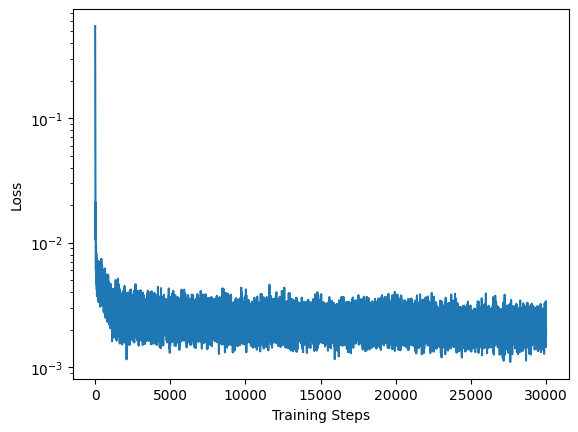

In [12]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [13]:
test_batch_size = 1000

In [14]:
my_net.eval()
test_labels = torch.multinomial(torch.ones(8), 
                                test_batch_size, 
                                replacement=True).to(device=device)
test_source = generate_source(test_batch_size).to(device=device)
with torch.inference_mode():
    traj = torchdiffeq.odeint(
        lambda t, x: my_net(x=x, t=t, labels=test_labels),
        test_source,
        torch.linspace(0, 1, 100, device=device),
        atol=1e-4,
        rtol=1e-4,
        method="dopri5",
    )

In [15]:
traj.shape

torch.Size([100, 1000, 2])

In [16]:
def plot_traj(traj: torch.Tensor, sample_size=1000):
    sample_size = min(sample_size, traj.shape[1])
    idx = torch.multinomial(torch.ones(traj.shape[1]), 
                            num_samples=sample_size, 
                            replacement=False)
    sub_traj = traj.cpu()[:, idx, :].permute([1, 0, 2])  # (sub_batch, t, 2)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(sub_traj[:, 0, 0], sub_traj[:, 0, 1],
                s=5, c="red")
    ax.scatter(sub_traj[:, -1, 0], sub_traj[:, -1, 1],
                s=5, c="blue")
    for ss_traj in sub_traj:
        ax.plot(ss_traj[:, 0], ss_traj[:, 1],
                 color="green",
                 alpha=0.1)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.grid()
    fig.show()

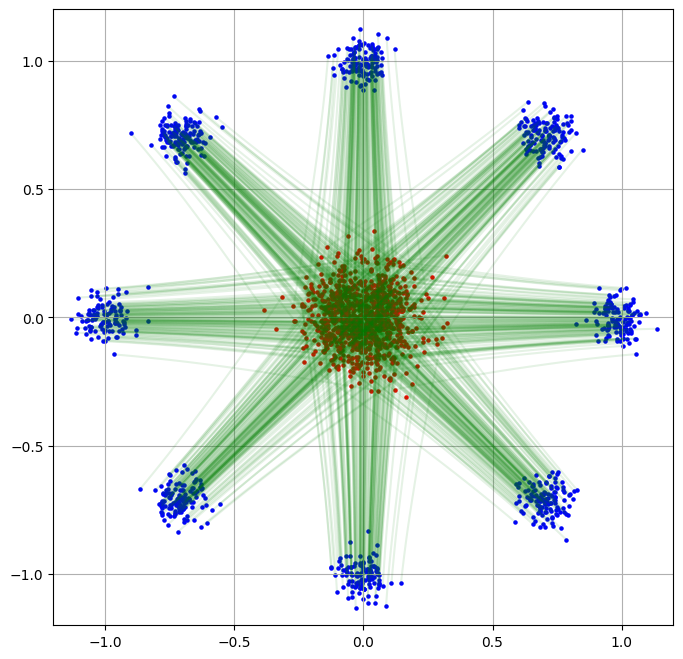

In [17]:
plot_traj(traj)

In [18]:
my_net.eval()
test_labels = torch.full((test_batch_size, ), fill_value=0).to(device=device)
test_source = generate_source(test_batch_size).to(device=device)
with torch.inference_mode():
    traj = torchdiffeq.odeint(
        lambda t, x: my_net(x=x, t=t, labels=test_labels),
        test_source,
        torch.linspace(0, 1, 100, device=device),
        atol=1e-4,
        rtol=1e-4,
        method="dopri5",
    )

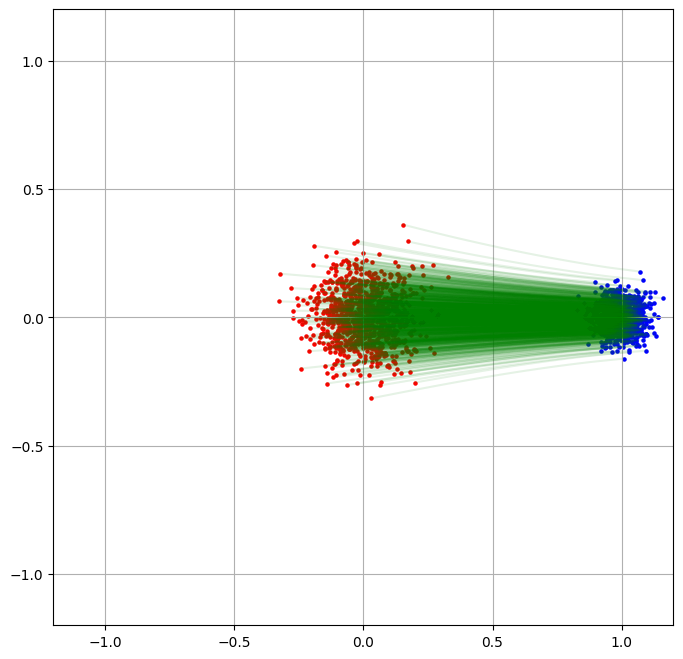

In [19]:
plot_traj(traj)

use the des data; do one more training and see the cm; try stochatic flow;

may try eigen-vi for the new submission

use scoring rule to test the asymmetry